## Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env3/lib/python3.5/site-

In [3]:
tf.__version__

'1.12.0'

In [4]:
import sys
sys.path.insert(0, '../.')

In [5]:
from data.segmentation_dataset_loader import *
from data.detection_dataset_loader import *
from model import *
from Trainer import *
from evaluation.evaluate import *

In [6]:
from data.postprocessing.nms import *

In [7]:
from datetime import datetime

## Utils

In [8]:
def prepare_dataset_feed_dict(model, dataset, train_fusion_rgb, train_fusion_fv_lidar, anchor_values, use_nms):
        # camera_tensor, lidar_tensor, fv_velo_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = sess.run(dataset)
        data = dataset.get_next(batch_size=1)

#         for i in range(len(data)):
#             data[i] = np.expand_dims(data[i], axis=0)
        camera_tensor, lidar_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = data
#         print(np.max(camera_tensor))
        d = {model.train_inputs_rgb: camera_tensor,
                model.train_inputs_lidar: lidar_tensor,
#                 model.Tr_velo_to_cam: Tr_velo_to_cam,
#                 model.R0_rect: R0_rect,
#                 model.P3: P3,
#                 model.shift_h: shift_h,
#                 model.shift_w: shift_w,
#                 model.anchors: anchor_values,
#                 model.use_nms: use_nms,
                model.y_true: label_tensor,
                model.train_fusion_rgb: train_fusion_rgb,
                model.is_training: False}
        return d

In [9]:
def sigmoid(x):
  return (1 / (1 + np.exp(-x.astype(np.float128)))).astype(np.float32)

def convert_prediction_into_real_values(label_tensor, 
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(512, 448), output_size=(128, 112), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :, :, -1])>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], ones_index[2][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])
#             if not is_label:
#               out[:3] = sigmoid(out[:3])
            out[:3] = np.tanh(out[:3])*0.5 * anchor[3:6] + anchor[:3]
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 40
            
            out[3:6] = np.exp(np.maximum(0, out[3:6])) * anchors
            
            k = ones_index[2][i]
            if not is_label:
              out[6] = sigmoid(out[6]) * np.pi/2 - np.pi/4
            if k == 0 and out[6] < 0:
                out[6] = out[6] + np.pi
                
            out[6] = out[6] + k * (np.pi/2)
                        
            result.append(out)
            
    return np.array(result)

In [10]:
def get_points(converted_points, calib_path, 
                x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                size=(512, 448, 40), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
#              and sigmoid(converted_points_[8]) < th2
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = converted_points_[6]
            result[15] = sigmoid(converted_points_[-1])

            calib_data = read_calib(calib_path)

            # x_range=(0, 70)
            # y_range=(-40, 40)
            # z_range=(-2.5, 1)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size

            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result


In [11]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0, get_neg=False):
#     return __read_label(label_path, calib_path, shift_h, shift_w, x_range=x_range, y_range=y_range, z_range=z_range, 
#                     size=size, get_actual_dims=get_actual_dims, from_file=from_file, translate_x=translate_x, translate_y=translate_y, ang=ang, get_neg=get_neg)



# def __read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
#                     size=(512, 448, 32), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0,
#                     get_neg=False):
    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = get_parameter(0)
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(z_range)
    indxes = np.array(list(map(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    if len(locations) > 0:
        locations[:, :2] = locations[:, :2] - np.array([translate_x, translate_y])

    # print('.......')
    

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 40) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 40) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 40) * y_fac + size[1]
            # print(dimension_length[i])
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            # print(dimension_length[i])
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            # print(dimension_height[i])
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)
            # print(dimension_height[i])

      


    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    output = [[-(locations[i][0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = np.array(output)
    if from_file:
        return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']
    else:
        return output, indxes




In [12]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
#     print(len(lines))
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car', 'Van', 'Truck', 'Tram']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    directions = np.array(angles>= 0).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])

    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#     print(len(locations))
    # print(z_range)

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    indxes = np.array(list(map(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]
        directions = directions[indx]

    if len(locations) > 0:
        locations[:, :3] = locations[:, :3] - np.array([translate_x, translate_y, -translate_z])

    # print('.......')
    # print(len(locations))

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 40) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 40) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 40) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      
    for i in range(len(locations)):
        if angles[i] < 0:
            angles[i] += 3.14

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    if from_file:
        return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2'], directions
    else:
        return output, indxes


In [13]:
def nms2(label, scores, max_output_size=100, iou_threshold=0.1, sess=None):
    boxes = []

    for j in range(0, len(label)):

        w = label[j][3]
        h = label[j][4] 
        x = label[j][0]
        y = label[j][1]
        a = label[j][6]
        

        polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
        xs = polygon[0::2]
        ys = polygon[1::2]
            
        boxes.append([xs[0], ys[0], xs[2], ys[2]])

    boxes = np.array(boxes)
    with tf.Graph().as_default():
        selected_indices = tf.image.non_max_suppression(
                    boxes, scores, max_output_size=max_output_size, iou_threshold=iou_threshold)
        if sess is not None:
            selected_indices = sess.run(selected_indices)
        else:
            with tf.Session() as sess:
                selected_indices = sess.run(selected_indices)

    return selected_indices


In [14]:
def write_predictions(final_output, th, new_file_path, apply_nms=False, sess=None):
#     now = datetime.now()
#     current_time = now.strftime("%H:%M:%S")
#     print("Current Time =", current_time)
    converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
    points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)
#     print(len(points))
    res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
#     with tf.device('/device:CPU:0'):
#     now = datetime.now()
#     current_time = now.strftime("%H:%M:%S")
#     print("Current Time =", current_time)
    if apply_nms:
            labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#             if len(labels) != len(points):
#                 print('not the same', new_file_path)
    #             return
            points = np.array(points)
            
            if len(labels) > 0:
                points = points[indxes]
                selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3, sess=sess)
            else:
                selected_idx = []

            if len(selected_idx) > 0:
                points = points[selected_idx]
                res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
            else:
                res=""
#     now = datetime.now()
#     current_time = now.strftime("%H:%M:%S")
#     print("Current Time =", current_time)
    text_file = open(new_file_path, "wb+")
    text_file.write(res.encode())
    text_file.close()

In [15]:
def write_predictions2(th, new_file_path, old_file_path, apply_nms=False, sess=None):
#     now = datetime.now()
#     current_time = now.strftime("%H:%M:%S")
#     print("Current Time =", current_time)
    
    res = []
    with open(old_file_path) as label_file:
            res = label_file.readlines()
    res = ''.join(res)
    points2 = res.split('\n')
    points = []
    for i in range(len(points2)):
        temp = []
        temp = points2[i].split(' ')
        points.append(temp)
#     print(points.split('\n')[0])
    
#     converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
#     points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)
#     print(len(points))
#     res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
#     with tf.device('/device:CPU:0'):
#     now = datetime.now()
#     current_time = now.strftime("%H:%M:%S")
#     print("Current Time =", current_time)
    if apply_nms:
            labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#             if len(labels) != len(points):
#                 print('not the same', new_file_path, len(labels), len(points))
    #             return
            points = np.array(points)
            
            if len(labels) > 0:
                points = points[indxes]
                selected_idx = nms2(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3, sess=sess)
            else:
                selected_idx = []

            if len(selected_idx) > 0:
                points = points[selected_idx]
                res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
            else:
                res=""
#     now = datetime.now()
#     current_time = now.strftime("%H:%M:%S")
#     print("Current Time =", current_time)
    text_file = open(new_file_path, "wb+")
    text_file.write(res.encode())
    text_file.close()

## Model

In [16]:
params = {
    'fusion': False
}
model = Model(graph=None, **params)

/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


## Evaluation

In [17]:
base_path = '../../../Data'

In [18]:
list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files)
ln = int(len(list_files) * 0.5)
list_files= list_files[ln:]

In [19]:
training = True

In [20]:
if training:
                file_name = '/trainsplit.txt'
else:
                file_name = '/valsplit.txt'
with open(base_path + file_name, 'r') as f:
                list_file_nums = f.readlines()
list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]

list_camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
list_lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
list_label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))

In [21]:
len(list_files)

3682

In [22]:
dir_name = 'predictions_fusion_bev_new'
dir_name = 'new_train_4'

In [23]:
!ls "../prediction_files/""$dir_name"

bev  nms


In [24]:
!rm -r "../prediction_files/""$dir_name"

In [25]:
!mkdir "../prediction_files/""$dir_name"
!mkdir "../prediction_files/""$dir_name""/bev/"
!mkdir "../prediction_files/""$dir_name""/bev/th05_2"
!mkdir "../prediction_files/""$dir_name""/bev/th05_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th10_2"
!mkdir "../prediction_files/""$dir_name""/bev/th10_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th20_2"
!mkdir "../prediction_files/""$dir_name""/bev/th20_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th30_2"
!mkdir "../prediction_files/""$dir_name""/bev/th30_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th40_2"
!mkdir "../prediction_files/""$dir_name""/bev/th40_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th50_2"
!mkdir "../prediction_files/""$dir_name""/bev/th50_2/data"

In [26]:
!mkdir "../prediction_files/""$dir_name""/nms/"
!mkdir "../prediction_files/""$dir_name""/nms/th05_2"
!mkdir "../prediction_files/""$dir_name""/nms/th05_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th10_2"
!mkdir "../prediction_files/""$dir_name""/nms/th10_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th20_2"
!mkdir "../prediction_files/""$dir_name""/nms/th20_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th30_2"
!mkdir "../prediction_files/""$dir_name""/nms/th30_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th40_2"
!mkdir "../prediction_files/""$dir_name""/nms/th40_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th50_2"
!mkdir "../prediction_files/""$dir_name""/nms/th50_2/data"

In [27]:
import numpy as np
import cv2
from data.data_utils.velodyne_points import *
from utils.utils import *
import math
import os
import random

from data.data_utils.reader import *
from data.data_utils.target_utils import *
from data.data_utils.fv_utils import *
from data.dataset_loader import *


class DetectionDatasetLoader(DatasetLoader):

    def _defaults(self, **kwargs):
        defaults = {
            'image_size': (370, 1224),
            'lidar_size': (512, 448, 40), 
            'anchors': np.array([3.9, 1.6, 1.5])
        }
        for k in kwargs:
            if k in defaults:
                defaults[k] = kwargs[k]
        return defaults
        

    def _init_generator(self, random_split = False):
        

        if random_split:

            list_files = list(map(lambda x: x.split('.')[0], os.listdir(self.base_path+'/data_object_image_3/training/image_3')))
            random.seed(self.random_seed)
            random.shuffle(list_files)

            camera_paths = list(map(lambda x: self.base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
            lidar_paths = list(map(lambda x: self.base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
            label_paths = list(map(lambda x: self.base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
            calib_paths = list(map(lambda x: self.base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
            
            if self.num_samples is None:
                ln = int(len(list_files) * self.training_per)
                final_sample = len(list_files)
            else:
                ln = int(self.num_samples * self.training_per)
                final_sample = self.num_samples

            if self.training:
                self.list_camera_paths = camera_paths[:ln]
                self.list_lidar_paths = lidar_paths[:ln]
                self.list_label_paths = label_paths[:ln]
                self.list_calib_paths = calib_paths[:ln]
            else:
                self.list_camera_paths = camera_paths[ln:final_sample]
                self.list_lidar_paths = lidar_paths[ln:final_sample]
                self.list_label_paths = label_paths[ln:final_sample]
                self.list_calib_paths = calib_paths[ln:final_sample]
        else:
            if self.training:
                file_name = '/trainsplit.txt'
            else:
                file_name = '/valsplit.txt'
            with open(self.base_path + file_name, 'r') as f:
                list_file_nums = f.readlines()
            list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]

            self.list_camera_paths = list(map(lambda x: self.base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
            self.list_lidar_paths = list(map(lambda x: self.base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
            self.list_label_paths = list(map(lambda x: self.base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
            self.list_calib_paths = list(map(lambda x: self.base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))


        # augment = self.training
        return self.__data_generator(self.base_path, 
                                    image_size=self.params['image_size'],
                                    lidar_size=self.params['lidar_size'], 
                                    anchors=self.params['anchors'],
                                    list_camera_paths=self.list_camera_paths[:], 
                                    list_lidar_paths=self.list_lidar_paths[:], 
                                    list_label_paths=self.list_label_paths[:], 
                                    list_calib_paths=self.list_calib_paths[:], 
                                    augment_translate=self.augment, 
                                    augment_rotate=self.augment,
                                    training=self.training)
                    
    def reset_generator(self):
        # augment = self.training
        self.generator = self.__data_generator(self.base_path, 
                                    image_size=self.params['image_size'],
                                    lidar_size=self.params['lidar_size'], 
                                    anchors=self.params['anchors'],
                                    list_camera_paths=self.list_camera_paths[:], 
                                    list_lidar_paths=self.list_lidar_paths[:], 
                                    list_label_paths=self.list_label_paths[:], 
                                    list_calib_paths=self.list_calib_paths[:], 
                                    augment_translate=self.augment, 
                                    augment_rotate=self.augment,
                                    training=self.training)
        

    def get_next(self, batch_size=1):
        camera_tensors = []
        lidar_tensors = []
        fv_velo_tensors = []
        label_tensors = []
        Tr_velo_to_cams = []
        R0_rects = []
        P3s = [] 
        shift_hs = []
        shift_ws = [] 

        for _ in range(batch_size):
            camera_tensor, lidar_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = list(next(self.generator))
            camera_tensors.append(camera_tensor)
            lidar_tensors.append(lidar_tensor)
            label_tensors.append(label_tensor)
            Tr_velo_to_cams.append(Tr_velo_to_cam)
            R0_rects.append(R0_rect)
            P3s.append(P3)
            shift_hs.append(shift_h)
            shift_ws.append(shift_w)

        camera_tensors = np.array(camera_tensors)
        lidar_tensors = np.array(lidar_tensors)
        label_tensors = np.array(label_tensors)
        
        Tr_velo_to_cams = np.array(Tr_velo_to_cams)
        R0_rects = np.array(R0_rects)
        P3s = np.array(P3s)
        shift_hs = np.array(shift_hs)
        shift_ws = np.array(shift_hs)
        return (camera_tensors, lidar_tensors, label_tensors, Tr_velo_to_cams, R0_rects, P3s, shift_hs, shift_ws)


    def __data_generator(self, base_path, image_size, lidar_size, anchors, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths, 
                        augment_translate=False, augment_rotate=False, training=True):

#         if training:
#             value = random.randint(0, 50)
#             random.seed(value)
#             random.shuffle(list_camera_paths)
#             random.seed(value)
#             random.shuffle(list_lidar_paths)
#             random.seed(value)
#             random.shuffle(list_label_paths)
#             random.seed(value)
#             random.shuffle(list_calib_paths)

        for camera_path, lidar_path, label_path, calib_path in zip(list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths):
                camera_image, shift_h, shift_w = read_camera(camera_path, image_size)
                h, w, _ = cv2.imread(camera_path).shape
                lidar_image = read_lidar(lidar_path, calib_path, lidar_size, img_height=h, img_width=w)
                _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(label_path, calib_path, shift_h, shift_w)
                label = get_target(label, directions,  anchors=anchors)
                camera_image = camera_image / 255.
                lidar_image = (lidar_image - 127. ) /127.
                yield(camera_image, lidar_image, label,
                            np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                            np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                            np.array(P3).reshape((3, 4)), 
                            np.array([shift_h]), 
                            np.array([shift_w])
                            )

       
                        




In [28]:
# import numpy as np
# import cv2
# from data.data_utils.velodyne_points import *
# from utils.utils import *
# import math
# import os
# import random

# from data.data_utils.reader import *
# from data.data_utils.target_utils import *
# from data.data_utils.fv_utils import *
# from data.dataset_loader import *


# class DetectionDatasetLoader(DatasetLoader):

#     def _defaults(self, **kwargs):
#         defaults = {
#             'image_size': (370, 1224),
#             'lidar_size': (512, 448, 40), 
#             'anchors': np.array([3.9, 1.6, 1.5])
#         }
#         for k in kwargs:
#             if k in defaults:
#                 defaults[k] = kwargs[k]
#         return defaults
        

#     def _init_generator(self, random_split = False):
        

#         if random_split:

#             list_files = list(map(lambda x: x.split('.')[0], os.listdir(self.base_path+'/data_object_image_3/training/image_3')))
#             random.seed(self.random_seed)
#             random.shuffle(list_files)

#             camera_paths = list(map(lambda x: self.base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
#             lidar_paths = list(map(lambda x: self.base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
#             label_paths = list(map(lambda x: self.base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
#             calib_paths = list(map(lambda x: self.base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
            
#             if self.num_samples is None:
#                 ln = int(len(list_files) * self.training_per)
#                 final_sample = len(list_files)
#             else:
#                 ln = int(self.num_samples * self.training_per)
#                 final_sample = self.num_samples

#             if self.training:
#                 self.list_camera_paths = camera_paths[:ln]
#                 self.list_lidar_paths = lidar_paths[:ln]
#                 self.list_label_paths = label_paths[:ln]
#                 self.list_calib_paths = calib_paths[:ln]
#             else:
#                 self.list_camera_paths = camera_paths[ln:final_sample]
#                 self.list_lidar_paths = lidar_paths[ln:final_sample]
#                 self.list_label_paths = label_paths[ln:final_sample]
#                 self.list_calib_paths = calib_paths[ln:final_sample]
#         else:
#             if self.training:
#                 file_name = '/trainsplit.txt'
#             else:
#                 file_name = '/valsplit.txt'
#             with open(self.base_path + file_name, 'r') as f:
#                 list_file_nums = f.readlines()
#             list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]

#             self.list_camera_paths = list(map(lambda x: self.base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
#             self.list_lidar_paths = list(map(lambda x: self.base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
#             self.list_label_paths = list(map(lambda x: self.base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
#             self.list_calib_paths = list(map(lambda x: self.base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))


#         # augment = self.training
#         return self.__data_generator(self.base_path, 
#                                     image_size=self.params['image_size'],
#                                     lidar_size=self.params['lidar_size'], 
#                                     anchors=self.params['anchors'],
#                                     list_camera_paths=self.list_camera_paths[:], 
#                                     list_lidar_paths=self.list_lidar_paths[:], 
#                                     list_label_paths=self.list_label_paths[:], 
#                                     list_calib_paths=self.list_calib_paths[:], 
#                                     augment_translate=self.augment, 
#                                     augment_rotate=self.augment,
#                                     training=self.training)
                    
#     def reset_generator(self):
#         # augment = self.training
#         self.generator = self.__data_generator(self.base_path, 
#                                     image_size=self.params['image_size'],
#                                     lidar_size=self.params['lidar_size'], 
#                                     anchors=self.params['anchors'],
#                                     list_camera_paths=self.list_camera_paths[:], 
#                                     list_lidar_paths=self.list_lidar_paths[:], 
#                                     list_label_paths=self.list_label_paths[:], 
#                                     list_calib_paths=self.list_calib_paths[:], 
#                                     augment_translate=self.augment, 
#                                     augment_rotate=self.augment,
#                                     training=self.training)
        

#     def get_next(self, batch_size=1):
#         camera_tensors = []
#         lidar_tensors = []
#         fv_velo_tensors = []
#         label_tensors = []
#         Tr_velo_to_cams = []
#         R0_rects = []
#         P3s = [] 
#         shift_hs = []
#         shift_ws = [] 

#         for _ in range(batch_size):
#             camera_tensor, lidar_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = list(next(self.generator))
#             camera_tensors.append(camera_tensor)
#             lidar_tensors.append(lidar_tensor)
#             label_tensors.append(label_tensor)
#             Tr_velo_to_cams.append(Tr_velo_to_cam)
#             R0_rects.append(R0_rect)
#             P3s.append(P3)
#             shift_hs.append(shift_h)
#             shift_ws.append(shift_w)

#         camera_tensors = np.array(camera_tensors)
#         lidar_tensors = np.array(lidar_tensors)
#         label_tensors = np.array(label_tensors)
        
#         Tr_velo_to_cams = np.array(Tr_velo_to_cams)
#         R0_rects = np.array(R0_rects)
#         P3s = np.array(P3s)
#         shift_hs = np.array(shift_hs)
#         shift_ws = np.array(shift_hs)
#         return (camera_tensors, lidar_tensors, label_tensors, Tr_velo_to_cams, R0_rects, P3s, shift_hs, shift_ws)


#     def __data_generator(self, base_path, image_size, lidar_size, anchors, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths, 
#                         augment_translate=False, augment_rotate=False, training=True):

#         for camera_path, lidar_path, label_path, calib_path in zip(list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths):
#                 camera_image, shift_h, shift_w = read_camera(camera_path, image_size)
#                 h, w, _ = cv2.imread(camera_path).shape
#                 lidar_image = read_lidar(lidar_path, calib_path, lidar_size, img_height=h, img_width=w)
#                 _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(label_path, calib_path, shift_h, shift_w)
#                 label = get_target(label, directions,  anchors=anchors)
#                 camera_image = camera_image / 255.
#                 lidar_image = lidar_image / 255.
#                 yield(camera_image, lidar_image, label,
#                             np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
#                             np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
#                             np.array(P3).reshape((3, 4)), 
#                             np.array([shift_h]), 
#                             np.array([shift_w])
#                             )



In [29]:
c_correct_test = []
c_loc_test = []
c_dim_test = []
prec_test = []
rec_test = []
theta_losses_test = []
theta_diffs_test = []

In [ ]:
with model.graph.as_default():
            
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True

  with tf.Session(config=config) as sess:
    model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))
#     model.saver.restore(sess, '../training_files/tmp_best2/model.ckpt-583440')
#     model.saver.restore(sess, '../training_files/tmp_best2/model.ckpt-403920')
#     model.saver.restore(sess, '../training_files/tmp/model.ckpt-773220')


    anchor_values = prepare_anchors()
    anchor_values = np.repeat(anchor_values, 1, axis=0)
    dataset = DetectionDatasetLoader(base_path='../../../Data', training_per=0.5, batch_size=1, random_seed=0, training=training)
   
    cls_losses = []
    reg_losses = []
    total_losses = []
    i = 0
    apply_nms=False
    
    try:    
        while i < len(list_files):
            feed_dict = prepare_dataset_feed_dict(model, dataset, False, False, anchor_values, False)

            final_output, iou, iou_dim, iou_loc, precision, recall, theta_loss, theta_accuracy = sess.run([model.final_output,\
                                                             model.iou, model.iou_dim, model.iou_loc,\
                                                             model.precision, model.recall, model.theta_reg_loss,\
                                                               model.theta_accuracy],\
                                                             feed_dict=feed_dict) 
                
#             print("i = ", i, ":", precision, recall, iou, iou_dim, iou_loc, theta_loss, theta_accuracy)
#             break
            i += 1
            c_correct_test.append(iou)
            c_loc_test.append(iou_loc)
            c_dim_test.append(iou_dim)
            prec_test.append(precision)
            rec_test.append(recall)
            theta_losses_test.append(theta_loss)
            theta_diffs_test.append(theta_accuracy)
#             if i % 100 == 0:
#                 print('i = ', i)
#             break
    except tf.errors.OutOfRangeError:
        pass
    except StopIteration:
        pass

In [ ]:
plt.hist(prec_test, bins=100)
plt.show()

In [ ]:
plt.hist(rec_test, bins=100)
plt.show()

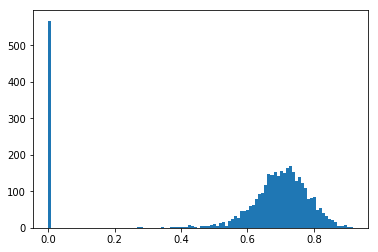

In [77]:
plt.hist(c_correct_test, bins=100)
plt.show()

In [91]:
len(np.array(c_correct_test)[(np.array(c_correct_test) >= 0.7)]) / len(c_correct_test)

0.45854172150565936

In [94]:
np.where((np.array(c_correct_test) >= 0.6) & (np.array(c_correct_test) < 0.7))

(array([   5,   12,   19, ..., 3789, 3795, 3797]),)

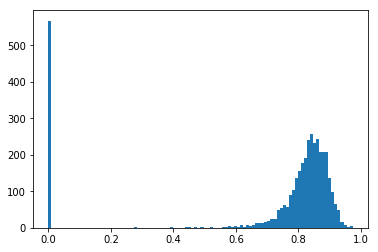

In [79]:
plt.hist(c_dim_test, bins=100)
plt.show()

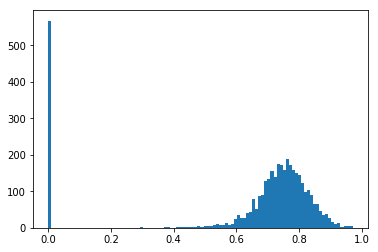

In [80]:
plt.hist(c_loc_test, bins=100)
plt.show()

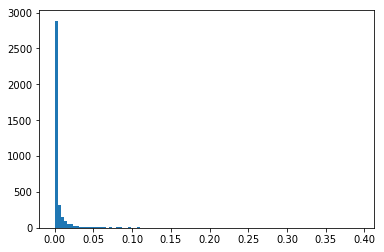

In [81]:
plt.hist(theta_losses_test, bins=100)
plt.show()

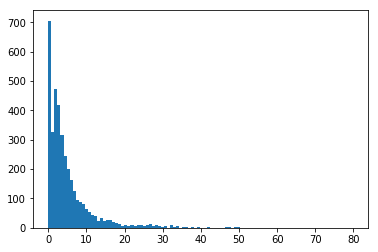

In [82]:
plt.hist(theta_diffs_test, bins=100)
plt.show()

In [28]:
c_correct = []
c_loc = []
c_dim = []
prec = []
rec = []
theta_losses = []
theta_diffs = []

In [36]:
with model.graph.as_default():
            
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True

  with tf.Session(config=config) as sess:
    model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))
#     model.saver.restore(sess, '../training_files/tmp_best2/model.ckpt-583440')
#     model.saver.restore(sess, '../training_files/tmp_best2/model.ckpt-403920')
#     model.saver.restore(sess, '../training_files/tmp/model.ckpt-773220')


    anchor_values = prepare_anchors()
    anchor_values = np.repeat(anchor_values, 1, axis=0)
    dataset = DetectionDatasetLoader(base_path='../../../Data', training_per=0.5, batch_size=1, random_seed=0, training=training)
   
    cls_losses = []
    reg_losses = []
    total_losses = []
    i = 0
    apply_nms=False
    
    try:    
        while i < 20:
            feed_dict = prepare_dataset_feed_dict(model, dataset, False, False, anchor_values, False)

            final_output, cls_loss, iou, iou_dim, iou_loc, precision, recall, theta_loss, theta_accuracy = sess.run([model.final_output,\
                                                             model.classification_loss, model.iou, model.iou_dim, model.iou_loc,\
                                                             model.precision, model.recall, model.theta_reg_loss,\
                                                               model.theta_accuracy],\
                                                             feed_dict=feed_dict) 
                
            print("i = ", i, ":", cls_loss, ",", precision, ",", recall,",", iou,",", iou_dim,",", iou_loc,",", theta_loss,",", theta_accuracy)
#             break
            i += 1
            c_correct.append(iou)
            c_loc.append(iou_loc)
            c_dim.append(iou_dim)
            prec.append(precision)
            rec.append(recall)
            theta_losses.append(theta_loss)
            theta_diffs.append(theta_accuracy)
#             if i % 100 == 0:
#                 print('i = ', i)
#             break
    except tf.errors.OutOfRangeError:
        pass
    except StopIteration:
        pass

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-750
i =  0 : 1.1391261 , 0.0 , 0.0 , 0.73631257 , 0.7363127 , 0.91286546 , 8.017587e-09 , 0.011394501
i =  1 : 659.12616 , 0.0 , 0.0 , 0.26287508 , 0.33653772 , 0.37177873 , 0.00919136 , 12.160409
i =  2 : 344.58572 , 0.0 , 0.0 , 0.2914801 , 0.5062076 , 0.34771088 , 0.005713444 , 7.722265
i =  3 : 192.33081 , 0.0 , 0.0 , 0.35612616 , 0.6849179 , 0.3563975 , 0.01201651 , 11.932662
i =  4 : 1.3720727 , 0.0 , 0.0 , 0.83131194 , 0.8614806 , 0.86710346 , 7.999487e-05 , 0.83989525
i =  5 : 751.06445 , 0.0 , 0.0 , 0.10579183 , 0.1833857 , 0.16801438 , 0.005761774 , 9.661304
i =  6 : 83.65052 , 0.0 , 0.0 , 0.5118041 , 0.8763283 , 0.50908804 , 0.015069668 , 15.624626
i =  7 : 26.738352 , 0.0 , 0.0 , 0.46113172 , 0.86230206 , 0.47068492 , 0.010485507 , 13.033234
i =  8 : 105.52931 , 0.0 , 0.0 , 0.27383566 , 0.6693918 , 0.3324652 , 0.016729921 , 14.580834
i =  9 : 765.5927 , 0.0 , 0.0 , 0.24013467 , 0.7167279 , 0.24916132 

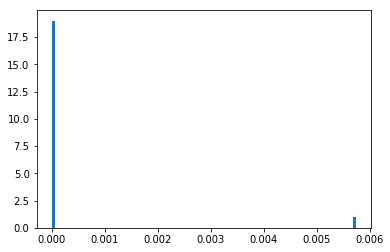

In [37]:
plt.hist(prec, bins=100)
plt.show()

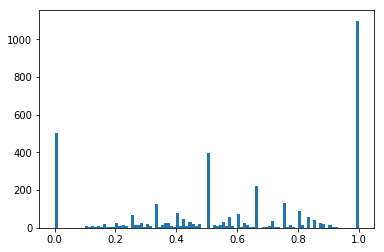

In [31]:
plt.hist(prec, bins=100)
plt.show()

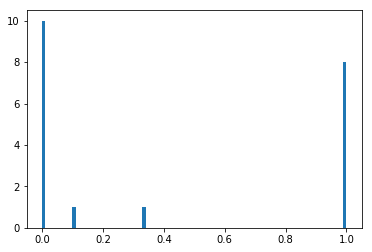

In [33]:
plt.hist(prec, bins=100)
plt.show()

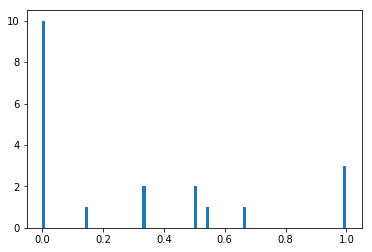

In [35]:
plt.hist(rec, bins=100)
plt.show()

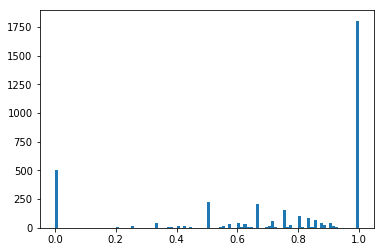

In [32]:
plt.hist(rec, bins=100)
plt.show()

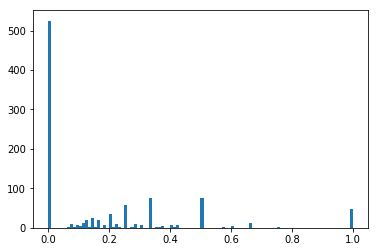

In [57]:
plt.hist(rec, bins=100)
plt.show()

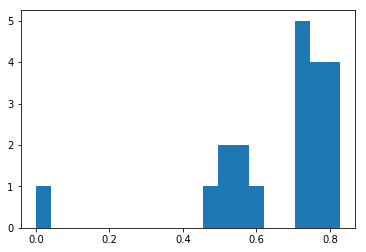

In [34]:
plt.hist(c_correct, bins=20)
plt.show()

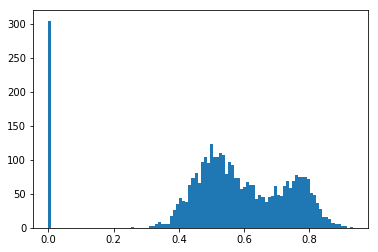

In [33]:
plt.hist(c_correct, bins=100)
plt.show()

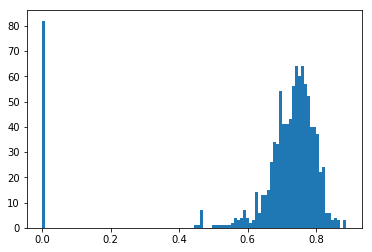

In [58]:
plt.hist(c_correct, bins=100)
plt.show()

In [35]:
len(np.array(c_correct)[np.array(c_correct) > 0.7]) / len(c_correct)

0.65

In [59]:
len(np.array(c_correct)[np.array(c_correct) > 0.7]) / len(c_correct)

0.677

In [67]:
# np.where((np.array(c_correct) >= 0.65) & (np.array(c_correct) <0.7))

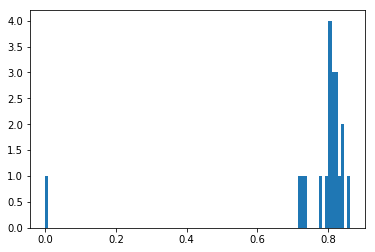

In [36]:
plt.hist(c_dim, bins=100)
plt.show()

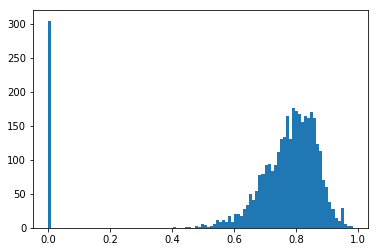

In [35]:
plt.hist(c_dim, bins=100)
plt.show()

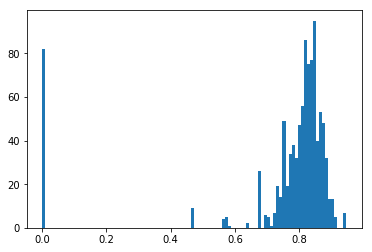

In [60]:
plt.hist(c_dim, bins=100)
plt.show()

In [39]:
len(np.array(c_dim)[np.array(c_dim) > 0.7]) / len(c_dim)

0.9

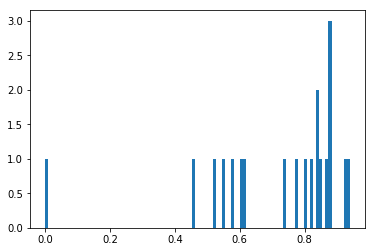

In [37]:
plt.hist(c_loc, bins=100)
plt.show()

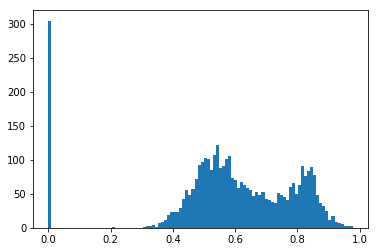

In [36]:
plt.hist(c_loc, bins=100)
plt.show()

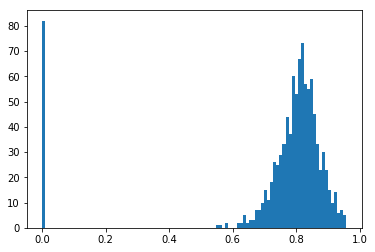

In [62]:
plt.hist(c_loc, bins=100)
plt.show()

In [41]:
len(np.array(c_loc)[np.array(c_loc) > 0.7]) / len(c_loc)

0.8

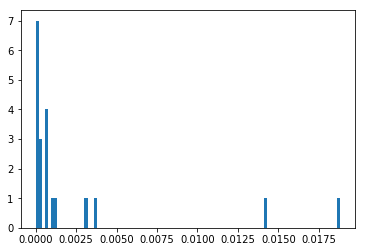

In [38]:
plt.hist(theta_losses, bins=100)
plt.show()

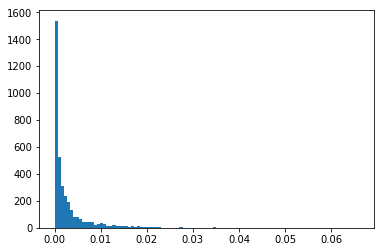

In [37]:
plt.hist(theta_losses, bins=100)
plt.show()

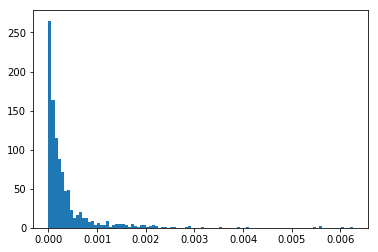

In [64]:
plt.hist(theta_losses, bins=100)
plt.show()

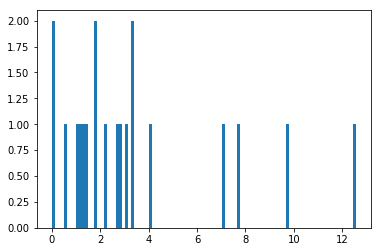

In [39]:
plt.hist(theta_diffs, bins=100)
plt.show()

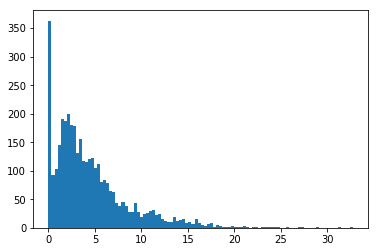

In [38]:
plt.hist(theta_diffs, bins=100)
plt.show()

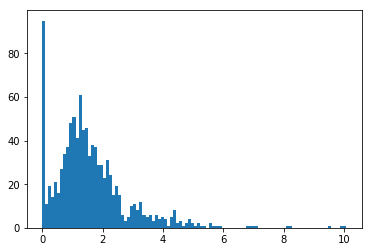

In [65]:
plt.hist(theta_diffs, bins=100)
plt.show()

In [66]:
# np.where((np.array(theta_diffs) >= 5) & (np.array(theta_diffs) <100))

In [44]:
with model.graph.as_default():
            
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True

  with tf.Session(config=config) as sess:
    model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))
#     model.saver.restore(sess, '../training_files/tmp_best2/model.ckpt-583440')
#     model.saver.restore(sess, '../training_files/tmp_best2/model.ckpt-403920')
#     model.saver.restore(sess, '../training_files/tmp/model.ckpt-773220')


    anchor_values = prepare_anchors()
    anchor_values = np.repeat(anchor_values, 1, axis=0)
    dataset = DetectionDatasetLoader(base_path='../../../Data', training_per=0.5, batch_size=1, random_seed=0, training=training)
   
    cls_losses = []
    reg_losses = []
    total_losses = []
    i = 0
    
    apply_nms=False
    
    try:    
#         j = 0
        while True:
            feed_dict = prepare_dataset_feed_dict(model, dataset, False, False, anchor_values, False)
#             if j < i:
#                 j += 1
#                 continue
#             elif j > i:
#                 break
#             j += 1
#             print(i, j)

            final_output= sess.run(model.final_output, feed_dict=feed_dict)
            

            if i < 20:
                current_file = list_files[i]
                
                th = 0.05
                new_file_path = '../prediction_files/' + dir_name + '/bev/th05_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, apply_nms=apply_nms, sess=sess)
                
                th = 0.1
                new_file_path = '../prediction_files/' + dir_name + '/bev/th10_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, apply_nms=apply_nms, sess=sess)
                
                th = 0.2
                new_file_path = '../prediction_files/' + dir_name + '/bev/th20_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, apply_nms=apply_nms, sess=sess)
                
                th = 0.3
                new_file_path = '../prediction_files/' + dir_name + '/bev/th30_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, apply_nms=apply_nms)
                
                th = 0.4
                new_file_path = '../prediction_files/' + dir_name + '/bev/th40_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, apply_nms=apply_nms)
                
                th = 0.50
                new_file_path = '../prediction_files/' + dir_name + '/bev/th50_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, apply_nms=apply_nms)

            else:
                break
                
#             print(final_output)
#             break
            i += 1
            if i % 100 == 0:
                print('i = ', i)
#             break
    except tf.errors.OutOfRangeError:
        pass
    except StopIteration:
        pass

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-3000


In [ ]:
#  th = 0.5
#                 new_file_path = '../prediction_files/' + dir_name + '/bev/th05_2/data/' + current_file + '.txt'
#                 write_predictions(final_output, th, new_file_path, apply_nms=apply_nms, sess=sess)
                
# #                 th = 0.005
# #                 new_file_path = '../prediction_files/' + dir_name + '/bev/th10_2/data/' + current_file + '.txt'
# #                 write_predictions(final_output, th, new_file_path, apply_nms=apply_nms, sess=sess)
                
#                 th = 0.001
#                 new_file_path = '../prediction_files/' + dir_name + '/bev/th20_2/data/' + current_file + '.txt'
#                 write_predictions(final_output, th, new_file_path, apply_nms=apply_nms, sess=sess)
                
#                 th = 0.0005
#                 new_file_path = '../prediction_files/' + dir_name + '/bev/th30_2/data/' + current_file + '.txt'
#                 write_predictions(final_output, th, new_file_path, apply_nms=apply_nms)
                
#                 th = 0.0001
#                 new_file_path = '../prediction_files/' + dir_name + '/bev/th40_2/data/' + current_file + '.txt'
#                 write_predictions(final_output, th, new_file_path, apply_nms=apply_nms)
                
# #                 th = 0.50
# #                 new_file_path = '../prediction_files/' + dir_name + '/bev/th50_2/data/' + current_file + '.txt'
# #                 write_predictions(final_output, th, new_file_path, apply_nms=apply_nms)


In [45]:
old_dir = 'predictions_bev'
if True:
            
#   config = tf.ConfigProto()
#   config.gpu_options.allow_growth = True

#   with tf.Session(config=config) as sess:
  if True:
    sess = None

    cls_losses = []
    reg_losses = []
    total_losses = []
    i = 0
    
    apply_nms=True
    
    try:    
        while True:

            if i < len(list_files):
                current_file = list_files[i]
                
                th = 0.05
                old_file_path = '../prediction_files/' + old_dir + '/bev/th05_2/data/' + current_file + '.txt'
                new_file_path = '../prediction_files/' + old_dir + '/nms/th05_2/data/' + current_file + '.txt'
                write_predictions2(th, new_file_path, old_file_path, apply_nms=apply_nms, sess=sess)
                
                th = 0.10
                old_file_path = '../prediction_files/' + old_dir + '/bev/th10_2/data/' + current_file + '.txt'
                new_file_path = '../prediction_files/' + old_dir + '/nms/th10_2/data/' + current_file + '.txt'
                write_predictions2(th, new_file_path, old_file_path, apply_nms=apply_nms, sess=sess)
                
                th = 0.20
                old_file_path = '../prediction_files/' + old_dir + '/bev/th20_2/data/' + current_file + '.txt'
                new_file_path = '../prediction_files/' + old_dir + '/nms/th20_2/data/' + current_file + '.txt'
                write_predictions2(th, new_file_path, old_file_path, apply_nms=apply_nms, sess=sess)
                
                th = 0.30
                old_file_path = '../prediction_files/' + old_dir + '/bev/th30_2/data/' + current_file + '.txt'
                new_file_path = '../prediction_files/' + old_dir + '/nms/th30_2/data/' + current_file + '.txt'
                write_predictions2(th, new_file_path, old_file_path, apply_nms=apply_nms, sess=sess)
                
                th = 0.40
                old_file_path = '../prediction_files/' + old_dir + '/bev/th40_2/data/' + current_file + '.txt'
                new_file_path = '../prediction_files/' + old_dir + '/nms/th40_2/data/' + current_file + '.txt'
                write_predictions2(th, new_file_path, old_file_path, apply_nms=apply_nms, sess=sess)
                
                th = 0.50
                old_file_path = '../prediction_files/' + old_dir + '/bev/th50_2/data/' + current_file + '.txt'
                new_file_path = '../prediction_files/' + old_dir + '/nms/th50_2/data/' + current_file + '.txt'
                write_predictions2(th, new_file_path, old_file_path, apply_nms=apply_nms, sess=sess)
                

            else:
                break
            i += 1
            if i % 100 == 0:
                print('i = ', i)
#             break
    except tf.errors.OutOfRangeError:
        pass
    except StopIteration:
        pass

FileNotFoundError: [Errno 2] No such file or directory: '../prediction_files/predictions_bev/bev/th05_2/data/000000.txt'

In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()

In [ ]:
len(list_files)

In [ ]:
['001966', '003202', '005344', '001177', '000534', '002694', '004495',\
          '001334', '000611', '007052', '001813', '000195', '004809', '000620',\
          '000803', '004562', '002591', '003033', '001587', '005985', '006109',\
          '004775']

In [ ]:
['001966', '003202', '005344', '001177', '000534', '002694', '004495', '001334',\
 '000611', '007052', '001813', '000195', '004809', '000620', '000803', '004562',\
 '002591', '003033', '005985', '006109', '004775']